<a href="https://colab.research.google.com/github/Neo-glitch/t.f-2.0-practice/blob/master/Image_Classification_API_with_Tf_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# sets path where vm can find dependencies for tf serving
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -


deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k
OK


In [ ]:
# updates all packages and install tf-model-server
!apt-get update && apt-get install tensorflow-model-server

Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic 

In [ ]:
import requests  # for making REST requests
import os
import json      # for sending data to model api
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import tensorflow.keras as keras

%matplotlib inline


#### Dataset preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0


x_train.shape

(50000, 32, 32, 3)

#### Model Definition and Evaluation

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])


history = model.fit(x_train, y_train, batch_size = 128, epochs = 10)

Epoch 1/10
391/391 [==============================] - 14s 31ms/step - loss: 1.4649 - sparse_categorical_accuracy: 0.4717
Epoch 2/10
391/391 [==============================] - 12s 30ms/step - loss: 1.0170 - sparse_categorical_accuracy: 0.6423
Epoch 3/10
391/391 [==============================] - 12s 31ms/step - loss: 0.8227 - sparse_categorical_accuracy: 0.7116
Epoch 4/10
391/391 [==============================] - 12s 31ms/step - loss: 0.7094 - sparse_categorical_accuracy: 0.7530
Epoch 5/10
391/391 [==============================] - 12s 31ms/step - loss: 0.6061 - sparse_categorical_accuracy: 0.7874
Epoch 6/10
391/391 [==============================] - 12s 30ms/step - loss: 0.5215 - sparse_categorical_accuracy: 0.8187
Epoch 7/10
391/391 [==============================] - 12s 31ms/step - loss: 0.4412 - sparse_categorical_accuracy: 0.8462
Epoch 8/10
391/391 [==============================] - 12s 31ms/step - loss: 0.3648 - sparse_categorical_accuracy: 0.8726
Epoch 9/10
391/391 [============

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"TEST Accuracy is: {test_accuracy}")

313/313 [==============================] - 2s 7ms/step - loss: 0.9488 - sparse_categorical_accuracy: 0.7475
TEST Accuracy is: 0.7475000023841858


### Saving model for production

In [ ]:
MODEL_DIR = "model/"
version = 1

export_path = os.path.join(MODEL_DIR, str(version))

export_path

'model/1'

In [ ]:
if os.path.isdir(export_path):
  # if path already exists remove it and things in it too 
  !rm -r {export_path}

In [ ]:
# saving the model for tf Serving, and saved model is in .pb format
keras.models.save_model(model, export_path, overwrite = True,
                        include_optimizer=True, save_format=None,
                        signatures=None, options=None
)

INFO:tensorflow:Assets written to: model/1/assets


#### Setting up production environment

In [ ]:
# exporting the MODEL_DIR to environ var. making path to be accessible for anywhere within sys, # control panel environ var.
os.environ["MODEL_DIR"] = os.path.abspath(MODEL_DIR)

In [ ]:
# Runnin the TF Serving REST API

# run bash in background
%%bash --bg
nohup tensorflow_model_server --rest_api_port=7000 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 5 in a separate thread.


In [ ]:
# print last 10 logs
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


#### API Interaction

In [ ]:
# create post request

random_image_index = np.random.randint(0, len(x_test))

random_image_index

4491

In [ ]:
# create json object to send request
data = json.dumps({
    # must be used for tf serving lib
    "signature_name": "serving_default",

    # what we want to make prediction on
    "instances": [x_test[random_image_index].tolist()]
})


data

'{"signature_name": "serving_default", "instances": [[[[0.6274509803921569, 0.7333333333333333, 0.5490196078431373], [0.5450980392156862, 0.6509803921568628, 0.5490196078431373], [0.5058823529411764, 0.611764705882353, 0.5568627450980392], [0.5098039215686274, 0.611764705882353, 0.5607843137254902], [0.5254901960784314, 0.6392156862745098, 0.5607843137254902], [0.5568627450980392, 0.6784313725490196, 0.5725490196078431], [0.5843137254901961, 0.6980392156862745, 0.596078431372549], [0.596078431372549, 0.7098039215686275, 0.6], [0.611764705882353, 0.7333333333333333, 0.611764705882353], [0.6274509803921569, 0.7490196078431373, 0.6039215686274509], [0.6431372549019608, 0.7725490196078432, 0.6039215686274509], [0.6, 0.7333333333333333, 0.5843137254901961], [0.5764705882352941, 0.6980392156862745, 0.5725490196078431], [0.615686274509804, 0.7215686274509804, 0.592156862745098], [0.6078431372549019, 0.7058823529411765, 0.596078431372549], [0.5529411764705883, 0.6470588235294118, 0.56862745098

In [ ]:
# sending post request
headers = {"content-type":"application/json"}   # type of data we are sending

json_response = requests.post(url = "Http://localhost:7000/v1/models/cifar10:predict", data = data, headers = headers)

json_response

<Response [200]>

In [ ]:
predictions = json.loads(json_response.text)["predictions"]

predictions

[[3.90955538e-05,
  1.53104168e-07,
  0.384094626,
  0.0433428921,
  0.44076243,
  0.105941251,
  0.00857337378,
  0.0171864983,
  3.27118469e-05,
  2.69755292e-05]]

class is : bird 



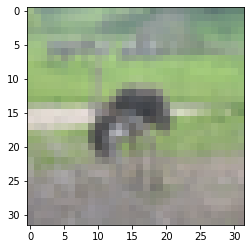

In [ ]:
plt.imshow(x_test[random_image_index])

print(f"class is : {class_names[y_test[random_image_index][0]]} \n")
  

In [ ]:
class_names[np.argmax(predictions[0])]

'deer'

In [ ]:
x_test[random_image_index].shape

(32, 32, 3)

In [ ]:
class_names[np.argmax(model.predict(x_test[random_image_index].reshape(1, 32, 32, 3))[0])]

'deer'

### Making Requests to a specific model

In [ ]:
# making request to version 1 model
version_1_json_response = requests.post(url="http://localhost:7000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)


predictions = json.loads(version_1_json_response.text)["predictions"]

predictions

[[3.90955538e-05,
  1.53104168e-07,
  0.384094626,
  0.0433428921,
  0.44076243,
  0.105941251,
  0.00857337378,
  0.0171864983,
  3.27118469e-05,
  2.69755292e-05]]